In [71]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [72]:
# Read in all orders.
orders = pd.read_csv('superstore_dataset2011-2015.csv', header=0, encoding='ISO-8859-1')

In [73]:
# Display dataset's data types.
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [74]:
# Dsiplay the dataset's number of rows and columns pre-formatting
orders.shape

(51290, 24)

In [75]:
# Display the dataset's basic stat.
orders.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


In [76]:
# Checking for null fields
df_null = round(100*(orders.isnull().sum())/len(orders), 2)
df_null

Row ID             0.00
Order ID           0.00
Order Date         0.00
Ship Date          0.00
Ship Mode          0.00
Customer ID        0.00
Customer Name      0.00
Segment            0.00
City               0.00
State              0.00
Country            0.00
Postal Code       80.51
Market             0.00
Region             0.00
Product ID         0.00
Category           0.00
Sub-Category       0.00
Product Name       0.00
Sales              0.00
Quantity           0.00
Discount           0.00
Profit             0.00
Shipping Cost      0.00
Order Priority     0.00
dtype: float64

In [77]:
# Drop Postal Code, since 80% of this column's data is missing
orders = orders.drop(columns=['Postal Code'])

In [78]:
orders = orders.dropna()

# Check the shape after dropping the rows with missing values
orders.shape

(51290, 23)

In [104]:
# Monetary column
rfm_m = orders.groupby('Customer ID')['Sales'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.columns = ['Customer ID', 'Sales']
rfm_m.head()

,Customer ID,Sales
0,AA-10315,13747.41300
1,AA-10375,5884.19500
2,AA-10480,17695.58978
3,AA-10645,15343.89070
4,AA-315,2243.25600


In [80]:
# Frequency column
rfm_f = orders.groupby('Customer ID')['Order ID'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head()

,Customer ID,Frequency
0,AA-10315,42
1,AA-10375,42
2,AA-10480,38
3,AA-10645,73
4,AA-315,8


In [81]:
# Recency column
orders['Order Date'] = orders['Order Date'].str.replace('/', '-')
orders['Order Date']


0          1-1-2011
1          1-1-2011
2          1-1-2011
3          1-1-2011
4          1-1-2011
            ...    
51285    31-12-2014
51286    31-12-2014
51287    31-12-2014
51288    31-12-2014
51289    31-12-2014
Name: Order Date, Length: 51290, dtype: object

In [82]:
orders['Order Date'] = pd.to_datetime(orders['Order Date'],format='%d-%m-%Y')
orders['Order Date']

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
51285   2014-12-31
51286   2014-12-31
51287   2014-12-31
51288   2014-12-31
51289   2014-12-31
Name: Order Date, Length: 51290, dtype: datetime64[ns]

In [83]:
max_date = max(orders['Order Date'])
max_date

Timestamp('2014-12-31 00:00:00')

In [84]:
orders['Diff'] = max_date - orders['Order Date']
rfm_r = orders.groupby('Customer ID')['Diff'].min()
rfm_r = rfm_r.reset_index().sort_values(by='Diff', ascending=False)
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r

,Customer ID,Diff
431,DK-2985,1206
484,DW-3195,1063
1460,SZ-10035,956
850,KD-6270,811
365,CT-1995,783
...,...,...
871,KL-6645,0
872,KM-16225,0
680,JA-15970,0
939,LP-7095,0


In [85]:
# Merging dataframes
rfm = pd.merge(rfm_m, rfm_f, on='Customer ID', how='inner')
rfm = pd.merge(rfm, rfm_r, on='Customer ID', how='inner')
rfm.columns = ['Customer ID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,Customer ID,Amount,Frequency,Recency
0,AA-10315,13747.41300,42,8
1,AA-10375,5884.19500,42,6
2,AA-10480,17695.58978,38,125
3,AA-10645,15343.89070,73,28
4,AA-315,2243.25600,8,2


Text(0.5, 0, 'Attributes')

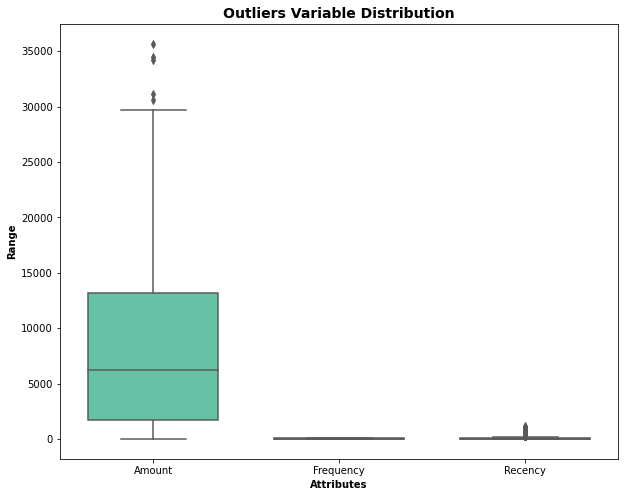

In [86]:
# Detect outliers

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [87]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

Text(0.5, 0, 'Attributes')

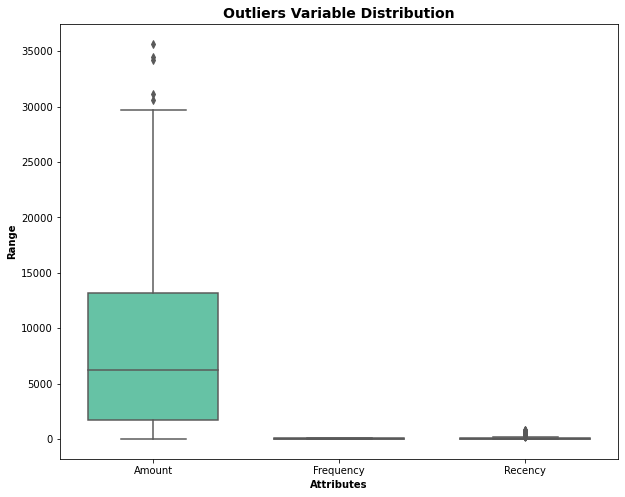

In [88]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

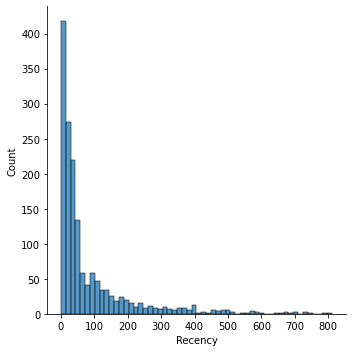

In [89]:
# Distribution for Recency
sns.displot(rfm['Recency'])

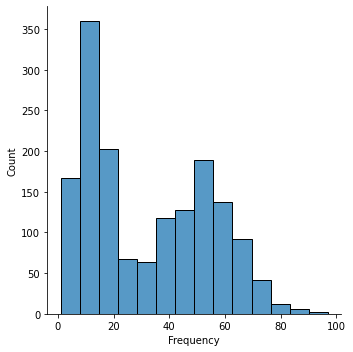

In [90]:
# Distribution for Frequency
sns.displot(rfm['Frequency'])

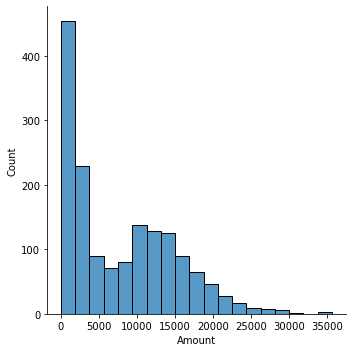

In [91]:
# Distribution for Amount
sns.displot(rfm['Amount'])

In [92]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = MinMaxScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(1587, 3)

In [93]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,0.385302,0.427083,0.009864
1,0.164803,0.427083,0.007398
2,0.496016,0.385417,0.154131
3,0.430070,0.750000,0.034525
4,0.062704,0.072917,0.002466


In [94]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [95]:
kmeans.labels_

array([3, 3, 3, ..., 1, 0, 3])

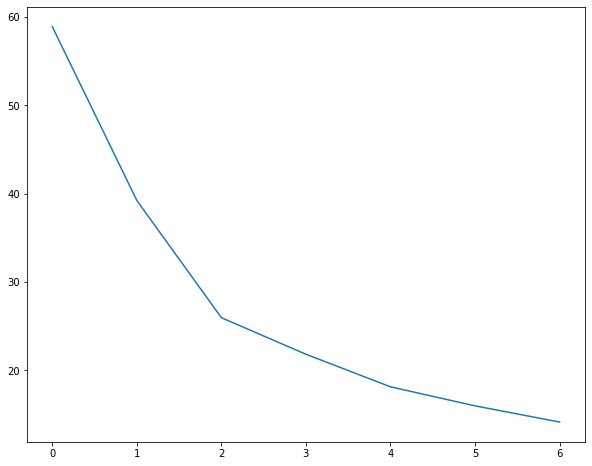

In [96]:
# Elbow-curve/SSD (Sum of Squares Distance)

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [97]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.5980445928433095
For n_clusters=3, the silhouette score is 0.5637907740004499
For n_clusters=4, the silhouette score is 0.49688787991989775
For n_clusters=5, the silhouette score is 0.41979339789423353
For n_clusters=6, the silhouette score is 0.38179077802376604
For n_clusters=7, the silhouette score is 0.3727685512939807
For n_clusters=8, the silhouette score is 0.3475436149175051


In [98]:
# Final model with k=4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [99]:
kmeans.labels_

array([2, 2, 2, ..., 1, 0, 2])

In [100]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,Customer ID,Amount,Frequency,Recency,Cluster_Id
0,AA-10315,13747.41300,42,8,2
1,AA-10375,5884.19500,42,6,2
2,AA-10480,17695.58978,38,125,2
3,AA-10645,15343.89070,73,28,1
4,AA-315,2243.25600,8,2,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

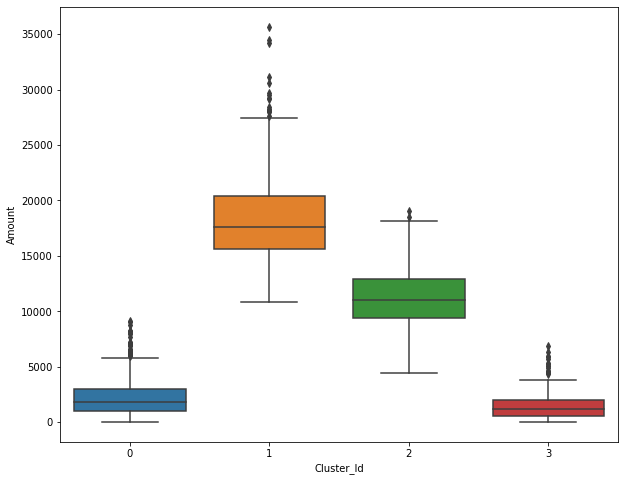

In [101]:
# Box plot to visualize Cluster Id vs Amount

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

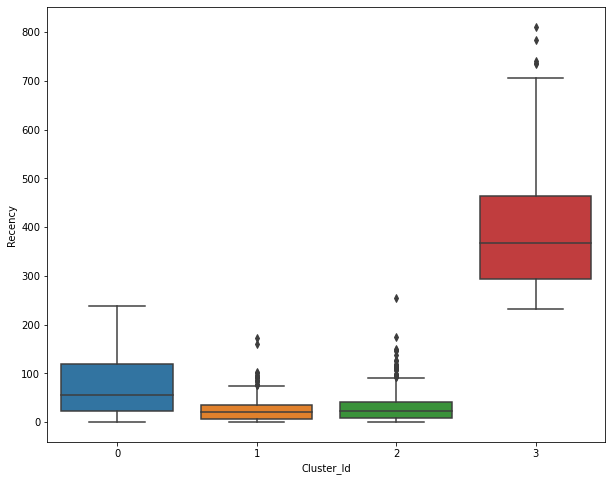

In [102]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

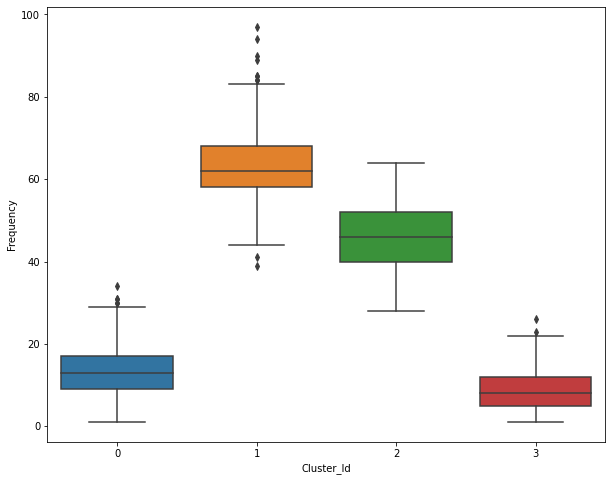

In [103]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

In [23]:
# Profit column
profit_column = orders.groupby('City')['Profit'].sum()
profit_column = profit_column.reset_index()
profit_column.columns = ['City', 'Profit']
profit_column.head()

,City,Profit
0,Aachen,1116.981
1,Aalen,283.005
2,Aalst,152.310
3,Aba,-1475.556
4,Abadan,233.820


In [24]:
# Sales column
sales_column = orders.groupby('City')['Sales'].sum()
sales_column = sales_column.reset_index()
sales_column.columns = ['City', 'Sales']
sales_column.head()

,City,Sales
0,Aachen,3803.151
1,Aalen,979.695
2,Aalst,387.330
3,Aba,1064.124
4,Abadan,1354.950


In [25]:
# Shipping Cost column
shippingCost_column = orders.groupby('City')['Shipping Cost'].sum()
shippingCost_column = shippingCost_column.reset_index()
shippingCost_column.columns = ['City', 'Shipping Cost']
shippingCost_column.head()

,City,Shipping Cost
0,Aachen,391.28
1,Aalen,81.97
2,Aalst,30.19
3,Aba,122.45
4,Abadan,116.22


In [26]:
# Merging dataframes
profit_sales = pd.merge(profit_column, sales_column, on='City', how='inner')
profit_sales_shippingCost = pd.merge(profit_sales, shippingCost_column, on='City', how='inner')
profit_sales_shippingCost.columns = ['City', 'Profit', 'Sales', 'Shipping Cost']
profit_sales_shippingCost.head()

,City,Profit,Sales,Shipping Cost
0,Aachen,1116.981,3803.151,391.28
1,Aalen,283.005,979.695,81.97
2,Aalst,152.310,387.330,30.19
3,Aba,-1475.556,1064.124,122.45
4,Abadan,233.820,1354.950,116.22


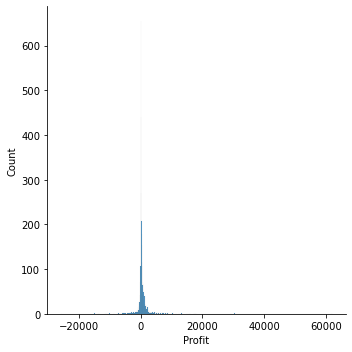

In [27]:
sns.displot(profit_sales_shippingCost['Profit'])

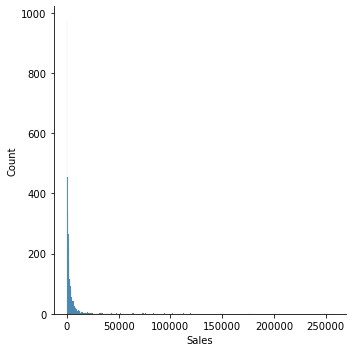

In [28]:
sns.displot(profit_sales_shippingCost['Sales'])

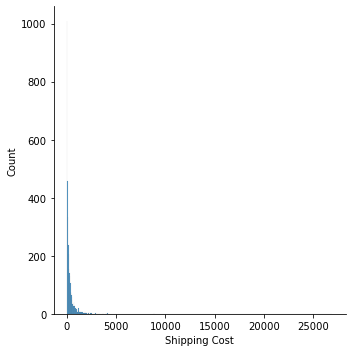

In [29]:
sns.displot(profit_sales_shippingCost['Shipping Cost'])

In [52]:
# Rescaling the attributes

psc = profit_sales_shippingCost[['Profit', 'Sales', 'Shipping Cost']]

# Instantiate
scaler = StandardScaler()

# fit_transform
psc_scaled = scaler.fit_transform(psc)
psc_scaled.shape

(3636, 3)

In [54]:
psc_scaled = pd.DataFrame(psc_scaled)
psc_scaled.columns = ['Profit', 'Sales', 'Shipping Cost']
psc_scaled.head()

,Profit,Sales,Shipping Cost
0,0.338114,0.034240,0.018865
1,-0.057152,-0.262208,-0.284782
2,-0.119096,-0.324403,-0.335614
3,-0.890628,-0.253343,-0.245043
4,-0.080464,-0.222808,-0.251159


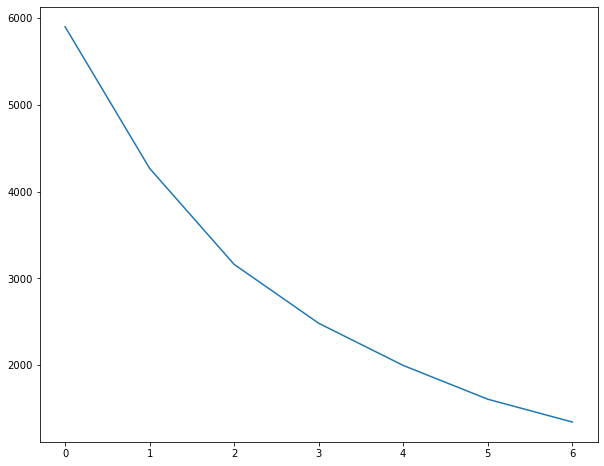

In [55]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(psc_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)
# y-axis: SSD
# x-axis: Number of clusters
# Choose a balance point to avoid over-fitting.

In [57]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(psc_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(psc_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
# The higher the point, the higher similarities between items within a cluster and 
# the higher dissimilarites bettwen items in different clusters.
# Choose a balance number to avoid over-fitting.

For n_clusters=2, the silhouette score is 0.925380329063089
For n_clusters=3, the silhouette score is 0.8980731919941513
For n_clusters=4, the silhouette score is 0.7455373649099596
For n_clusters=5, the silhouette score is 0.7494744699723406
For n_clusters=6, the silhouette score is 0.6278540004381941
For n_clusters=7, the silhouette score is 0.6550884444699756
For n_clusters=8, the silhouette score is 0.613568105681946


In [111]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(psc_scaled)

KMeans(max_iter=50, n_clusters=3)

In [112]:
 kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [113]:
# assign the label
psc['Cluster_Id'] = kmeans.labels_
psc.head()

,Profit,Sales,Shipping Cost,Cluster_Id
0,1116.981,3803.151,391.28,0
1,283.005,979.695,81.97,0
2,152.310,387.330,30.19,0
3,-1475.556,1064.124,122.45,0
4,233.820,1354.950,116.22,0


<AxesSubplot:xlabel='Cluster_Id', ylabel='Profit'>

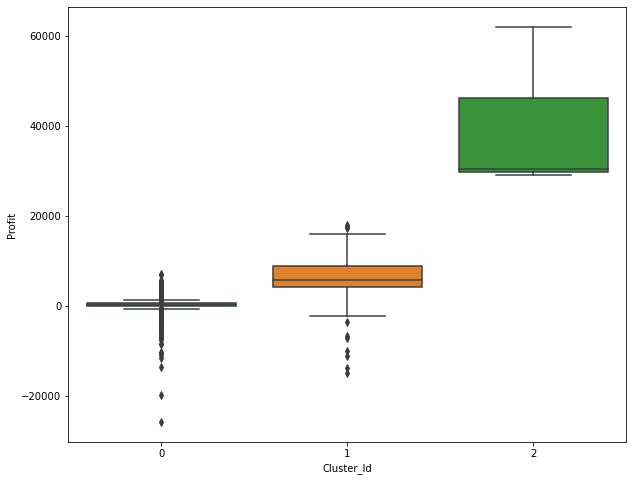

In [114]:
# Box plot to visualize Cluster Id vs Profit

sns.boxplot(x='Cluster_Id', y='Profit', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Sales'>

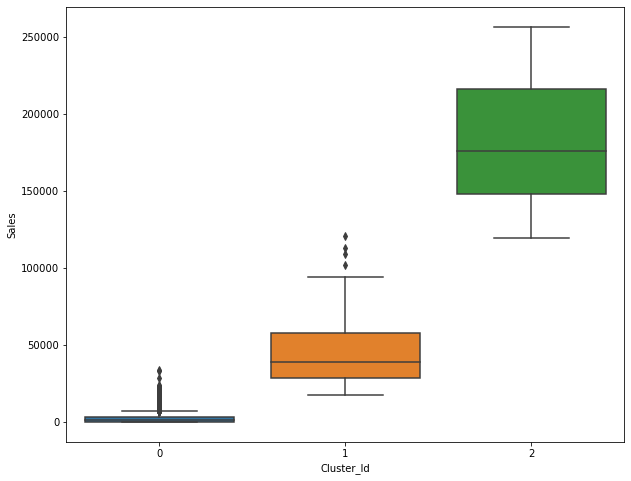

In [115]:
# Box plot to visualize Cluster Id vs Sales

sns.boxplot(x='Cluster_Id', y='Sales', data=psc)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Shipping Cost'>

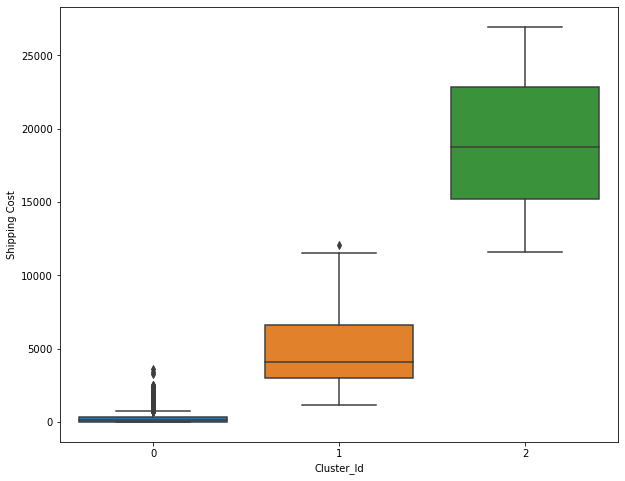

In [116]:
# Box plot to visualize Cluster Id vs Shipping Cost

sns.boxplot(x='Cluster_Id', y='Shipping Cost', data=psc)